In [64]:
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import SparsePCA, KernelPCA
from sklearn.decomposition import PCA
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler


# Load data

In [65]:
# Constants
DIR_PATH = '../Consolidated_Features'
SUBJECT_LIST = [
    "3128", "3129", "3130", "3131", "3132", "3133", "3136", "3137", "3138", "3139", 
    "3140", "3141", "3142", "3143", "3147", "3148", "3149", "3150", "3151", "3152", 
    "3153", "3154", "3155", "3156", "3158", "3159", "3160", "3162", "6037", "6038", 
    "6043", "6044", "6045", "6046", "6047", "6048", "6049"
]
NUM_STIMULI = 5
STIMULUS_TYPES = ['Rest', 'Reading', 'SpeechPrep', 'Speech', 'Recovery']
NUM_FEATURES = 5
FEATURE_TYPES = ['HR', 'PAT', 'PEP', 'PPGamp', 'PTTrecip']

# List to store dataframes for MI subjects
dataframes_mi = []

# List to store dataframes for healthy control subjects
dataframes_ht = []

# List to store dataframes for all subjects
dataframes_all = []

# Variables to track index of MI, healthy control, and all subjects
sub_mi = -1
sub_ht = -1
sub_all = -1

# Loop through all subjects
for sub in os.listdir(DIR_PATH):
    subject_id = int(sub[3:])  # Extract subject ID from directory name

    if str(subject_id) in SUBJECT_LIST:

        # Check if the subject ID belongs to MI subjects
        if str(subject_id).startswith('3'):
            sub_mi += 1
            dataframes_mi.append([])

            # Loop through stimuli
            for stim in range(NUM_STIMULI):
                dataframes_mi[sub_mi].append([])

                # Loop through features
                for feat in range(NUM_FEATURES):
                    dataframes_mi[sub_mi][stim].append([])
                    feat_load = os.path.join(DIR_PATH, 'sub' + str(subject_id), 'stim' + str(stim) + '_' + FEATURE_TYPES[feat] + '.csv')
                    data = pd.read_csv(feat_load)
                    dataframes_mi[sub_mi][stim][feat] = data.values
        
        # Check if the subject ID belongs to healthy control subjects
        elif str(subject_id).startswith('6'):
            sub_ht += 1
            dataframes_ht.append([])

            # Loop through stimuli
            for stim in range(NUM_STIMULI):
                dataframes_ht[sub_ht].append([])

                # Loop through features
                for feat in range(NUM_FEATURES):
                    dataframes_ht[sub_ht][stim].append([])
                    feat_load = os.path.join(DIR_PATH, 'sub' + str(subject_id), 'stim' + str(stim) + '_' + FEATURE_TYPES[feat] + '.csv')
                    data = pd.read_csv(feat_load)
                    dataframes_ht[sub_ht][stim][feat] = data.values
        
        # For all subjects
        sub_all += 1
        dataframes_all.append([])

        # Loop through stimuli
        for stim in range(NUM_STIMULI):
            dataframes_all[sub_all].append([])

            # Loop through features
            for feat in range(NUM_FEATURES):
                dataframes_all[sub_all][stim].append([])
                feat_load = os.path.join(DIR_PATH, 'sub' + str(subject_id), 'stim' + str(stim) + '_' + FEATURE_TYPES[feat] + '.csv')
                data = pd.read_csv(feat_load)
                dataframes_all[sub_all][stim][feat] = data.values

print("Data loading completed.")

Data loading completed.


# Normalize to baseline

In [66]:
# %% Baseline correction (normalization)

# Determine MI (Myocardial Infarction) vs. HT (Healthy Control) status based on subject identifier
mi_subjects = ["3128", "3129", "3130", "3131", "3132", "3133", "3136", "3137", "3138", "3139", 
               "3140", "3141", "3142", "3143", "3147", "3148", "3149", "3150", "3151", "3152", 
               "3153", "3154", "3155", "3156", "3158", "3159", "3160", "3162"]

# Healthy Control subjects
ht_subjects = ["6037", "6038", "6043", "6044", "6045", "6046", "6047", "6048", "6049"]

# Initialize lists to store mean difference, normalized data, and labels
mean_difference_all = []  # Stores the mean difference between feature and baseline for all subjects, stimuli, and features
normalized_data_all = []  # Stores the normalized data for all subjects, stimuli, and features
labels_all = []  # Stores the labels for all subjects, stimuli, and features

# Number of data points and half of it
num_data_points = 80  # Total number of data points
data_points_half = round(num_data_points / 2)  # Half of the total number of data points

# Loop through each subject
for subject_index, subject_id in enumerate(SUBJECT_LIST):
    normalized_data_subject = []  # Stores the normalized data for the current subject
    labels_subject = []  # Stores the labels for the current subject

    # Loop through each stimulus
    for stimulus_index in range(NUM_STIMULI):
        normalized_data_stimulus = []  # Stores the normalized data for the current stimulus
        labels_stimulus = []  # Stores the labels for the current stimulus

        # Loop through each feature
        for feature_index in range(NUM_FEATURES):
            baseline_data = dataframes_all[subject_index][0][feature_index][:, 1]  # Baseline data
            baseline_midpoint = baseline_data[len(baseline_data) // 2 - data_points_half:len(baseline_data) // 2 + data_points_half]  # Midpoint of baseline data
            feature_data = dataframes_all[subject_index][stimulus_index][feature_index][:, 1]  # Feature data
            feature_midpoint = feature_data[len(feature_data) // 2 - data_points_half:len(feature_data) // 2 + data_points_half]  # Midpoint of feature data

            # Calculate mean difference between feature and baseline
            mean_difference = (np.mean(feature_midpoint) - np.mean(baseline_midpoint)) / np.mean(baseline_midpoint)
            mean_difference_all.append(mean_difference)

            # Normalize the data and assign labels

            if stim == 0:
                normalized_data = (baseline_midpoint - np.mean(baseline_midpoint)) / np.mean(baseline_midpoint)

                if subject_id in mi_subjects:
                    labels = np.zeros_like(normalized_data)  # Assign label 0

                else:
                    labels = np.ones_like(normalized_data)  # Assign label 1
            else:
                normalized_data = (feature_midpoint - np.mean(baseline_midpoint)) / np.mean(baseline_midpoint)
                
                if subject_id in mi_subjects:
                    labels = np.zeros_like(normalized_data)  # Assign label 0
                
                else:
                    labels = np.ones_like(normalized_data)  # Assign label 1

            normalized_data_stimulus.append(normalized_data)
            labels_stimulus.append(labels)

        normalized_data_subject.append(normalized_data_stimulus)
        labels_subject.append(labels_stimulus)

    normalized_data_all.append(normalized_data_subject)
    labels_all.append(labels_subject)

c:\Users\dyzha\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dyzha\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


## Get normalized data and labels for SpeechPrep for all features

In [67]:
# Initialize aggregated data and labels specifically for the "Speech Prep" stimulus
aggregated_data_speech_prep = []  # Stores the aggregated normalized data for all features for "Speech Prep"
aggregated_labels_speech_prep = []  # Stores the aggregated labels for all features for "Speech Prep"

for feature_index in range(NUM_FEATURES):
    aggregated_data_feature = []  # Temporary list to aggregate normalized data for the current feature for "Speech Prep"
    aggregated_labels_feature = []  # Temporary list to aggregate labels for the current feature for "Speech Prep"

    # Loop through each subject
    for subject_index in range(len(SUBJECT_LIST)):
        # Extend the temporary lists with data and labels for the current feature and subject for "Speech Prep"
        aggregated_data_feature.extend(normalized_data_all[subject_index][2][feature_index])  # Assuming index 2 corresponds to "Speech Prep"
        aggregated_labels_feature.extend(labels_all[subject_index][2][feature_index])  # Assuming index 2 corresponds to "Speech Prep"

    # Append the aggregated data and labels for the current feature to the overall lists for "Speech Prep"
    aggregated_data_speech_prep.append(aggregated_data_feature)
    aggregated_labels_speech_prep.append(aggregated_labels_feature)

# Determine the minimum length among all lists in data_all_1
min_length_data = min(len(lst) for lst in aggregated_data_speech_prep)

# Truncate each inner list in data_all_1 to have the minimum length
data_all_1_truncated = [lst[:min_length_data] for lst in aggregated_data_speech_prep]

# Convert the truncated list of lists to a Numpy array
data_all_1_array = np.array(data_all_1_truncated)

# Reshape the Numpy array to have 5 columns
num_columns = 5
data_all_1_array = data_all_1_array.reshape(-1, num_columns)

# Determine the minimum length among all lists in data_y_all_1
min_length_data_y = min(len(lst) for lst in aggregated_labels_speech_prep)

# Truncate each inner list in data_y_all_1 to have the minimum length
data_y_all_1_truncated = [lst[:min_length_data_y] for lst in aggregated_labels_speech_prep]

# Convert the truncated list of lists to a Numpy array
data_y_all_1_array = np.array(data_y_all_1_truncated)

# Reshape the Numpy array to have 5 columns
data_y_all_1_array = data_y_all_1_array.reshape(-1, num_columns)

# Extract features and labels
feats = data_all_1_array[:, :]
X = feats
labels = data_y_all_1_array[:, 0]
y = labels

In [68]:
# Calculate z-scores for each feature
z_scores = np.abs((feats - np.mean(feats, axis=0)) / np.std(feats, axis=0))

# Define a threshold for z-score to identify outliers
threshold = 3

# Find indices of outliers
outlier_indices = np.where(z_scores > threshold)

# Remove outliers
feats_cleaned = np.delete(feats, outlier_indices[0], axis=0)
labels_cleaned = np.delete(labels, outlier_indices[0])

feats_upc = PCA(n_components=5).fit_transform(feats_cleaned)
feats_spc = PCA(n_components=5).fit_transform(StandardScaler().fit_transform(feats_cleaned))

X = feats_cleaned
y = labels_cleaned

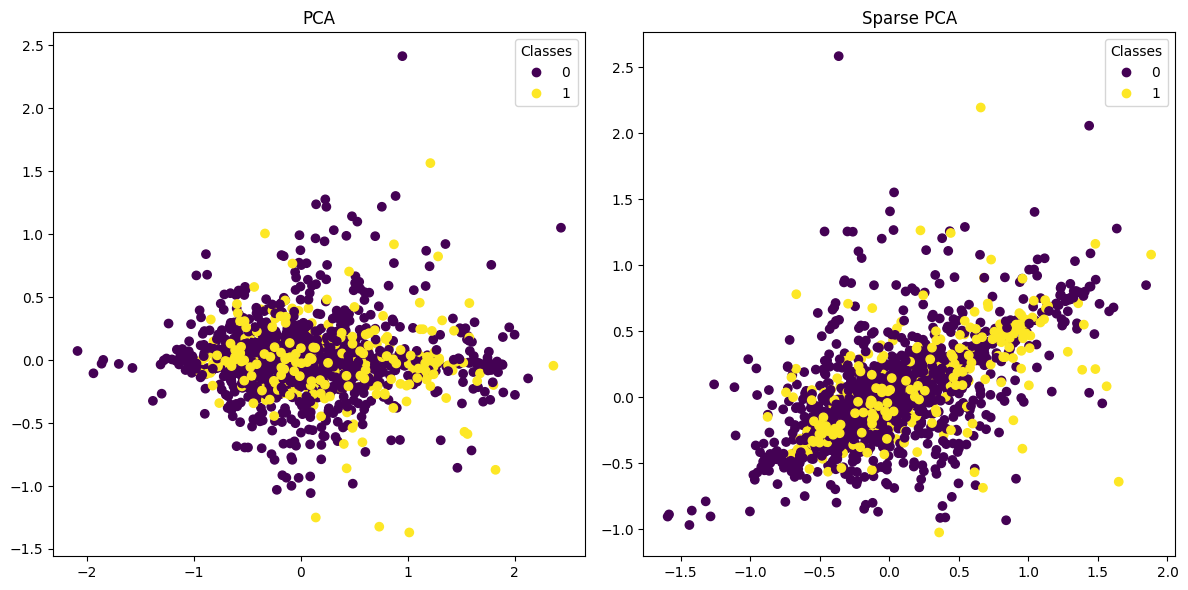

In [69]:
# Perform PCA
pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)

# Perform SparsePCA
spca = SparsePCA(n_components=3)
spca.fit(X)
X_spca = spca.transform(X)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot PCA results
scatter_pca = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, label='PCA')
axes[0].set_title('PCA')

# Plot Sparse PCA results
scatter_spca = axes[1].scatter(X_spca[:, 0], X_spca[:, 1], c=y, label='Sparse PCA')
axes[1].set_title('Sparse PCA')

# Add legend to both subplots
legend_pca = axes[0].legend(*scatter_pca.legend_elements(), title='Classes')
legend_spca = axes[1].legend(*scatter_spca.legend_elements(), title='Classes')

# Combine legends
#fig.legend([scatter_pca, scatter_spca], labels=['PCA', 'Sparse PCA'], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

# Robust PCA
scaler = RobustScaler()
# X_scaled = scaler.fit_transform(X)

# rpca = PCA(n_components=5)
# rpca.fit(X_scaled)
# X_rpca = rpca.transform(X_scaled)

# # Plot Sparse PCA results
# scatter_rpca = axes[2].scatter(X_rpca[:, 0], X_rpca[:, 1], c=y, label='Robust PCA')
# axes[2].set_title('Robust PCA')

plt.tight_layout()
plt.show()

In [70]:
# Plot PCA results
#fig, axes = plt.subplots(1, 2, figsize=(16, 4))
#axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y)
#axes[0].set_title('PCA')

# Print and plot Sparse PCA results
'''
#axes[1].scatter(X_spca[:,0], X_spca[:,1],c=y)
#axes[1].set_title('Sparse PCA')
'''

# Get the absolute loadings of the principal components
absolute_loadings = np.abs(pca.components_)
print("Absolute loadings:")
print(absolute_loadings)

# Zip the feature names with the absolute loadings for each principal component

# Assuming FEATURE_TYPES is a list containing the names of your original features
feature_importance = list(zip(FEATURE_TYPES, absolute_loadings))
print("Feature importance:")
print(feature_importance)


Absolute loadings:
[[0.44932204 0.44711984 0.46667683 0.43764127 0.43459914]
 [0.14752963 0.40995939 0.86285879 0.22088655 0.12981584]
 [0.6885517  0.57118627 0.12085912 0.30586434 0.30246136]]
Feature importance:
[('HR', array([0.44932204, 0.44711984, 0.46667683, 0.43764127, 0.43459914])), ('PAT', array([0.14752963, 0.40995939, 0.86285879, 0.22088655, 0.12981584])), ('PEP', array([0.6885517 , 0.57118627, 0.12085912, 0.30586434, 0.30246136]))]


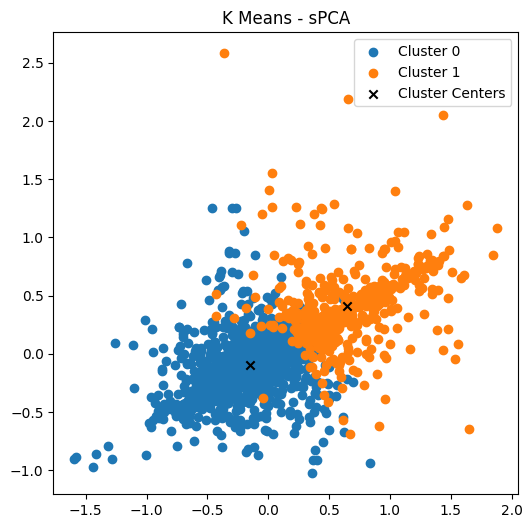

In [82]:
from sklearn.cluster import KMeans

fig, axes = plt.subplots(1, 1, figsize=(6, 6))

NUM_CLUSTERS = 2

# kmeans = KMeans(n_clusters=NUM_CLUSTERS)  # Assuming you want to divide subjects into 2 clusters (healthy vs. unhealthy)

# # Fit KMeans to your data
# kmeans.fit(X_pca)

# # Get cluster assignments for each subject
# kmeans_labels = kmeans.labels_

# # Get cluster centers
# cluster_centers = kmeans.cluster_centers_

# # Plotting data points with labels
# for i in range(NUM_CLUSTERS):
#     cluster_points = X_pca[kmeans_labels == i]
#     axes[0].scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

# # Plotting cluster centers
# axes[0].scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='x', label='Cluster Centers')

# axes[0].set_title('PCA')
# axes[0].legend()

kmeans = KMeans(n_clusters=NUM_CLUSTERS)  # Assuming you want to divide subjects into 2 clusters (healthy vs. unhealthy)

# Fit KMeans to your data
kmeans.fit(X_spca)

# Get cluster assignments for each subject
cluster_labels = kmeans.labels_

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
kmeans_labels_2 = kmeans.labels_

# Plotting data points with labels
for i in range(NUM_CLUSTERS):
    cluster_points = X_spca[kmeans_labels_2 == i] # labels_cleaned is the correct label
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

# Plotting cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='x', label='Cluster Centers')

#plt.xlabel('HR')
#plt.ylabel('PAT')
#plt.xlabel('Feature 1')
#plt.ylabel('Feature 2')
plt.title('K Means - sPCA')
plt.legend()

# kmeans = KMeans(n_clusters=NUM_CLUSTERS)  # Assuming you want to divide subjects into 2 clusters (healthy vs. unhealthy)

# # Fit KMeans to your data
# kmeans.fit(X_rpca)

# # Get cluster assignments for each subject
# cluster_labels = kmeans.labels_

# # Get cluster centers and labels
# cluster_centers = kmeans.cluster_centers_
# kmeans_labels_3 = kmeans.labels_

# # Plotting data points with labels
# for i in range(NUM_CLUSTERS):
#     cluster_points = X_rpca[kmeans_labels_3 == i] # labels_cleaned is the correct label
#     axes[2].scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

# # Plotting cluster centers
# axes[2].scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='x', label='Cluster Centers')

# #plt.xlabel('HR')
# #plt.ylabel('PAT')
# #plt.xlabel('Feature 1')
# #plt.ylabel('Feature 2')
# axes[2].set_title('Robust PCA')
# axes[2].legend()

In [86]:
# Calculate silhouette score
from sklearn.metrics import silhouette_score

#silhouette_avg_pca = silhouette_score(X_pca, kmeans_labels)
silhouette_avg_spca = silhouette_score(X_spca, kmeans_labels_2)
#silhouette_avg_rpca = silhouette_score(X_rpca, kmeans_labels_3)

#print(silhouette_avg_pca)
print(silhouette_avg_spca)
#print(silhouette_avg_rpca)

from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(X_spca, kmeans_labels_2)
print(ch_score)

0.5197765569346166
2011.2616714903436


In [73]:
# Comparing each label and outputting 1 if they are the same, 0 otherwise
comparison_results = [1 if kmeans_label == real_label else 0 for kmeans_label, real_label in zip(kmeans_labels, y)]
comparison_results_2 = [1 if kmeans_label == real_label else 0 for kmeans_label, real_label in zip(kmeans_labels_2, y)]

# print("Comparison results:", comparison_results)
acc = np.mean(comparison_results)
acc_2 = np.mean(comparison_results_2)

print(acc)
print(acc_2)

0.7519316795445303
0.7515250101667345


In [74]:
from sklearn.cluster import DBSCAN

# Initialize and fit DBSCAN
epsilon = 0.5  # Example value for epsilon (you may need to tune this)
min_samples = 5  # Example value for min_samples (you may need to tune this)
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(X)

# Retrieve cluster labels and core samples
cluster_labels = dbscan.labels_
core_samples_mask = np.zeros_like(cluster_labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Number of clusters in labels, ignoring noise if present
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

# Analyze clusters
print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Estimated number of clusters: 1
Estimated number of noise points: 89


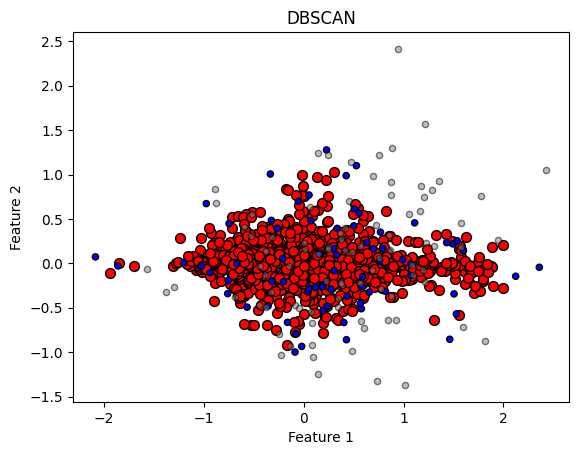

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting function
def plot_clusters(X_pca, cluster_labels, core_samples_mask, n_clusters, n_noise):
    # Create a mask for noise points
    noise_mask = (cluster_labels == -1)

    # Define colors for clusters and noise points
    colors = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
    core_colors = ['red']

    # Plot core samples
    plt.scatter(X_pca[core_samples_mask, 0], X_pca[core_samples_mask, 1], 
                c=core_colors[0], edgecolor='k', s=50, label='Core Samples')

    # Plot non-core samples (assigned clusters)
    plt.scatter(X_pca[~core_samples_mask & ~noise_mask, 0], X_pca[~core_samples_mask & ~noise_mask, 1], 
                c=colors[cluster_labels[~core_samples_mask & ~noise_mask]], edgecolor='k', s=20, label='Assigned Clusters')

    # Plot noise points
    plt.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], c='gray', edgecolor='k', s=20, alpha=0.5, label='Noise Points')

    # Add legend and labels
    plt.title('DBSCAN')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    #plt.legend()
    plt.show()

# Call the plotting function
plot_clusters(X_pca, cluster_labels, core_samples_mask, 2, n_noise)


Estimated number of clusters: 2
Estimated number of noise points: 0


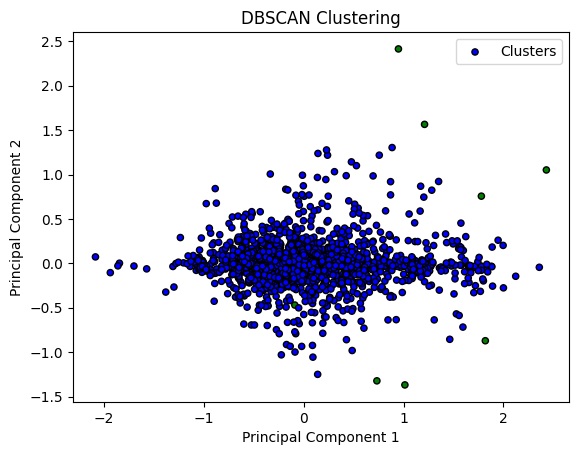

In [76]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_pca contains your data transformed by PCA
# Instantiate DBSCAN with epsilon and min_samples parameters
epsilon = 0.5  # Distance threshold for clustering
min_samples = 5  # Minimum number of samples in a neighborhood for a point to be considered as a core point
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)

# Fit DBSCAN to your PCA-transformed data
dbscan.fit(X_pca)

# Retrieve cluster labels and core samples
cluster_labels = dbscan.labels_

# Assign the two clusters
# You can use any method to identify the two clusters, such as k-means on the DBSCAN-transformed data
# Here, we'll simply assign points with label 0 and label 1 as two separate clusters
cluster_labels[cluster_labels == 0] = 0
cluster_labels[cluster_labels != 0] = 1

# Number of clusters in labels, ignoring noise if present (-1 represents noise)
n_clusters = 2
n_noise = list(cluster_labels).count(-1)

# Analyze clusters
print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

# Plotting function
def plot_clusters(X, cluster_labels, n_clusters, n_noise):
    # Define colors for clusters and noise points
    colors = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

    # Plot clusters
    plt.scatter(X[:, 0], X[:, 1], c=colors[cluster_labels], edgecolor='k', s=20, label='Clusters')

    # Add legend and labels
    plt.title('DBSCAN Clustering')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

# Call the plotting function
plot_clusters(X_pca, cluster_labels, n_clusters, n_noise)


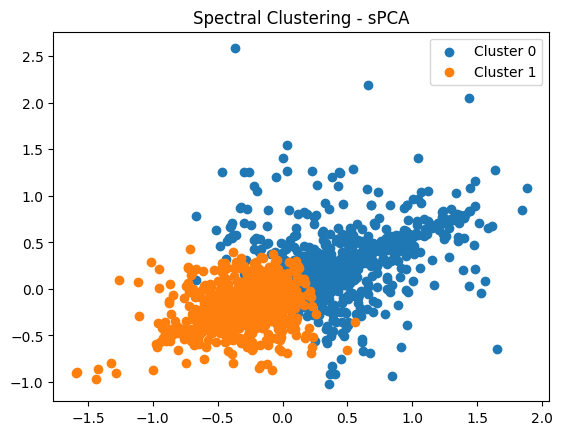

0.41160860922113834
1802.6861396933557


In [88]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# Apply Spectral Clustering
sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
cluster_labels = sc.fit_predict(X_spca)


# Plot the clusters
for i in range(NUM_CLUSTERS):
    cluster_points = X_spca[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
plt.title('Spectral Clustering - sPCA')
#plt.xlabel('Principal Component 1')
#plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
silhouette_avg_spca = silhouette_score(X_spca, cluster_labels)
print(silhouette_avg_spca)
ch_score = calinski_harabasz_score(X_spca, cluster_labels)
print(ch_score)


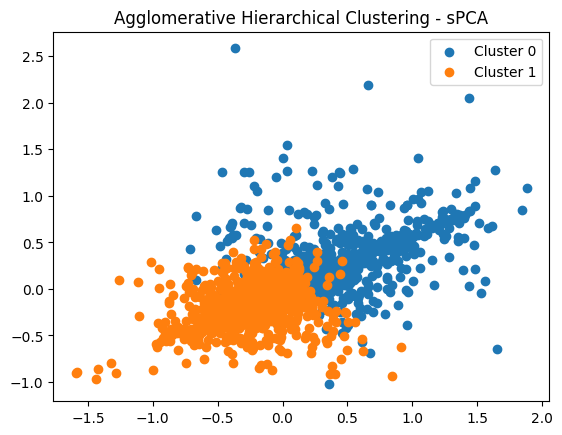

0.4429702902160031


In [83]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Apply Agglomerative Hierarchical Clustering
agg_cluster = AgglomerativeClustering(n_clusters=2)
cluster_labels = agg_cluster.fit_predict(X_spca)

# Plot the clusters
for i in range(NUM_CLUSTERS):
    cluster_points = X_spca[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
plt.title('Agglomerative Hierarchical Clustering - sPCA')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
silhouette_avg_spca = silhouette_score(X_spca, cluster_labels)
print(silhouette_avg_spca)
ch_score = calinski_harabasz_score(X_spca, cluster_labels)
print(ch_score)